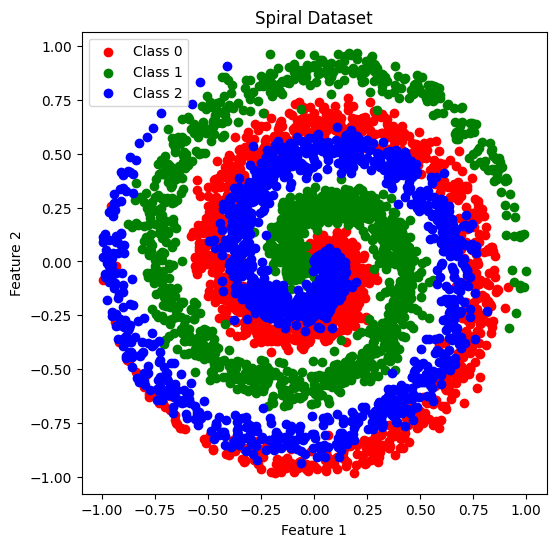

Epoch 1/250, Loss: 1.077702, Accuracy: 0.3971
Epoch 10/250, Loss: 0.333481, Accuracy: 0.8657
Epoch 20/250, Loss: 0.277019, Accuracy: 0.8743
Epoch 30/250, Loss: 0.250667, Accuracy: 0.8930
Epoch 40/250, Loss: 0.253226, Accuracy: 0.8879
Epoch 50/250, Loss: 0.230441, Accuracy: 0.9010
Epoch 60/250, Loss: 0.237303, Accuracy: 0.8937
Epoch 70/250, Loss: 0.223743, Accuracy: 0.9038
Epoch 80/250, Loss: 0.226404, Accuracy: 0.9035
Epoch 90/250, Loss: 0.224495, Accuracy: 0.9029
Epoch 100/250, Loss: 0.234358, Accuracy: 0.9010
Epoch 110/250, Loss: 0.216325, Accuracy: 0.9051
Epoch 120/250, Loss: 0.223319, Accuracy: 0.9022
Epoch 130/250, Loss: 0.215006, Accuracy: 0.9108
Epoch 140/250, Loss: 0.210072, Accuracy: 0.9095
Epoch 150/250, Loss: 0.208423, Accuracy: 0.9095
Epoch 160/250, Loss: 0.210083, Accuracy: 0.9083
Epoch 170/250, Loss: 0.212151, Accuracy: 0.9060
Epoch 180/250, Loss: 0.204450, Accuracy: 0.9098
Epoch 190/250, Loss: 0.217532, Accuracy: 0.9035
Epoch 200/250, Loss: 0.226020, Accuracy: 0.8994
Epo

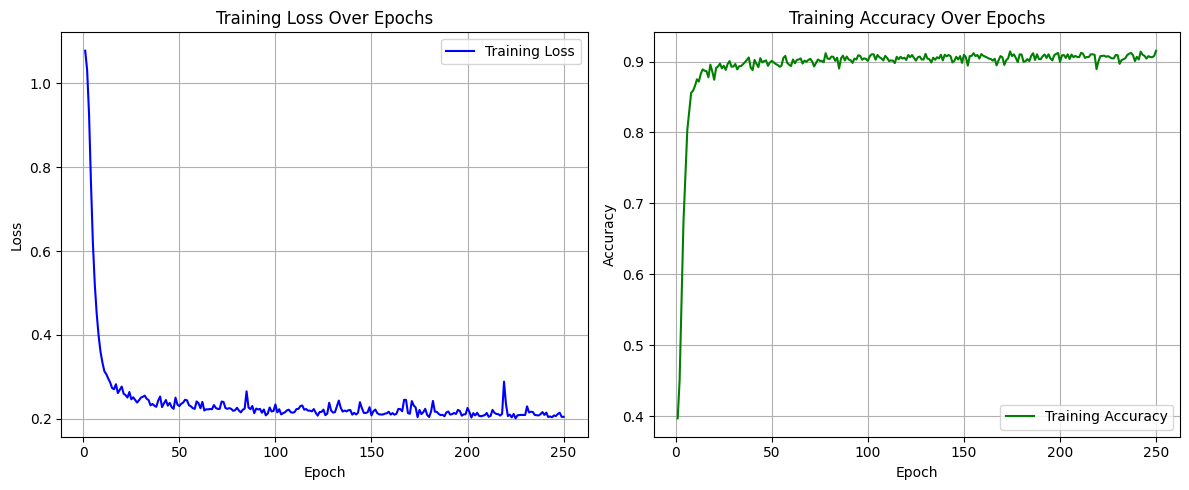

Test Accuracy: 0.8941


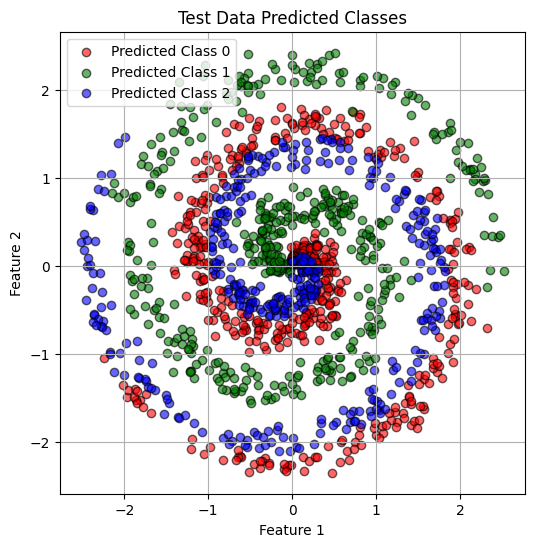

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(23)
np.random.seed(23)

def generate_spiral_data(points_per_class, num_classes, noise=0.2):
    """
    Generates a spiral dataset.

    Args:
        points_per_class (int): Number of points per class.
        num_classes (int): Number of spiral classes.
        noise (float): Standard deviation of Gaussian noise added to the data.

    Returns:
        X (np.ndarray): Feature matrix of shape (points_per_class * num_classes, 2).
        y (np.ndarray): Labels of shape (points_per_class * num_classes,).
    """
    X = []
    y = []
    for class_number in range(num_classes):
        ix = range(points_per_class * class_number, points_per_class * (class_number + 1))
        r = np.linspace(0.0, 1, points_per_class)  # Radius
        theta = np.linspace(class_number * 4, (class_number + 1) * 4, points_per_class) + np.random.randn(points_per_class) * noise
        X_class = np.c_[r * np.sin(theta * 2.5), r * np.cos(theta * 2.5)]
        X.append(X_class)
        y += [class_number] * points_per_class
    X = np.concatenate(X)
    y = np.array(y)
    return X, y

# Parameters for the spiral dataset
points_per_class = 1500
num_classes = 3  # Number of classes
noise = 0.2

# Generate the spiral data
X, y = generate_spiral_data(points_per_class, num_classes, noise)

# Visualize the generated spiral dataset
plt.figure(figsize=(6,6))
colors = ['red', 'green', 'blue', 'purple', 'orange']
for class_number in range(num_classes):
    plt.scatter(X[y == class_number, 0], X[y == class_number, 1], 
                color=colors[class_number % len(colors)], label=f'Class {class_number}')
plt.title('Spiral Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define the classical MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim1=64, hidden_dim2=64, num_classes=2):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize the model
model = MLPClassifier(input_dim=2, hidden_dim1=64, hidden_dim2=64, num_classes=num_classes)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training loop
num_epochs = 250
batch_size = 64
loss_history = []
accuracy_history = []

# Create data loader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = loss_func(logits, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(logits, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_X.size(0)
    loss_value = epoch_loss / total
    accuracy = correct / total
    loss_history.append(loss_value)
    accuracy_history.append(accuracy)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss_value:.6f}, Accuracy: {accuracy:.4f}")

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_history, label='Training Accuracy', color='green')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
model.eval()
with torch.no_grad():
    pred_y = model(X_test)
    _, predicted_test = torch.max(pred_y, 1)
    test_accuracy = (predicted_test == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

predicted_test_np = predicted_test.numpy()
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()

# Plot predicted classes for test data
plt.figure(figsize=(6, 6))

for class_number in range(num_classes):
    # Select points predicted to belong to the current class
    idx = predicted_test_np == class_number
    plt.scatter(
        X_test_np[idx, 0], 
        X_test_np[idx, 1], 
        color=colors[class_number % len(colors)], 
        label=f'Predicted Class {class_number}', 
        alpha=0.6, 
        edgecolor='k'
    )

plt.title('Test Data Predicted Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


